### DEMDP07 
# Stochastic Optimal Economic Growth Model

Welfare maximizing social planner must decide how much society should consume and invest. Unlike the deterministic model, this model allows arbitrary constant relative risk aversion, capital depreciation, and stochastic production shocks.  It lacks a known closed-form solution.

- States
    -     s       stock of wealth
- Actions
    -     k       capital investment
- Parameters
    - alpha     relative risk aversion
    - beta      capital production elasticity
    - gammma    capital survival rate
    - sigma     production shock volatility
    - delta     discount factor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, DPmodel, DPoptions, qnwlogn, demo
import seaborn as sns
import pandas as pd

### Model parameters

In [2]:
α, β, γ, σ, δ = 0.2, 0.5, 0.9, 0.1, 0.9

## Analytic results

The deterministic steady-state values for this model are

In [3]:
kstar = ((1 - δ*γ)/(δ*β))**(1/(β-1))  # steady-state capital investment

sstar = γ*kstar + kstar**β            # steady-state wealth

## Numeric results

### State space
The state variable is s="Wealth", which we restrict to $s\in[5, 10]$. 

Here, we represent it with a Chebyshev basis, with $n=10$ nodes.

In [4]:
n, smin, smax = 10, 5, 10
basis = BasisChebyshev(n, smin, smax, labels=['Wealth'])

### Continuous state shock distribution

In [5]:
m = 5
e, w = qnwlogn(m, -σ**2/2,σ**2)

### Action space
The choice variable k="Investment" must be nonnegative.

In [6]:
def bounds(s, i=None, j=None):
    return np.zeros_like(s), 0.99*s

### Reward function
The reward function is the utility of consumption=$s-k$.

In [7]:
def reward(s, k, i=None, j=None):
    sk = s - k
    u = sk**(1-α) / (1-α)
    ux= -sk **(-α)
    uxx = -α * sk**(-1-α)
    return u, ux, uxx

### State transition function
Next period, wealth will be equal to production from available initial capital $k$, that is $s' = k^\beta$

In [8]:
def transition(s, k, i=None, j=None, in_=None, e=None):
    g = γ * k  + e * k**β
    gx = γ  + β*e * k**(β-1)
    gxx = β*(β-1)*e * k**(β-2)
    return g, gx, gxx

### Model structure
The value of wealth $s$ satisfies the Bellman equation
\begin{equation*}
V(s) = \max_k\left\{\log(s-k) + \delta V(k^\beta)  \right\}
\end{equation*}

To solve and simulate this model,use the CompEcon class `DPmodel`

In [9]:
growth_model = DPmodel(basis, reward, transition, bounds,e=e,w=w,
                       x=['Investment'],
                       discount=δ )

### Solving the model

Solving the growth model by collocation.

In [10]:
S = growth_model.solve()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       8.2e+00    0.0035
   1       9.6e+00    0.1350
   2       2.2e+00    0.2040
   3       3.8e-02    0.2666
   4       7.0e-06    0.3038
   5       2.0e-14    0.3212
Elapsed Time =    0.32 Seconds


`DPmodel.solve` returns a pandas `DataFrame` with the following data:

We are also interested in the shadow price of wealth (the first derivative of the value function).

To analyze the dynamics of the model, it also helps to compute the optimal change of wealth.

In [11]:
S['shadow price'] = growth_model.Value(S['Wealth'],1)
S['D.Wealth'] = transition(S['Wealth'], S['Investment'],e=1)[0] - S['Wealth']
S.head()

,Wealth,value,resid,Investment,shadow price,D.Wealth
Wealth,,,,,,
5.000000,5.000000,17.793592,4.324111e-09,3.997670,0.999535,0.597321
5.050505,5.050505,17.843995,-1.837414e-09,4.032514,0.996440,0.586869
5.101010,5.101010,17.894243,-4.078480e-09,4.067300,0.993391,0.576314
5.151515,5.151515,17.944339,-3.954337e-09,4.102028,0.990386,0.565657
5.202020,5.202020,17.994283,-2.583509e-09,4.136700,0.987425,0.554898


### Solving the model by Linear-Quadratic Approximation
The DPmodel.lqapprox solves the linear-quadratic approximation, in this case arround the steady-state. It returns a LQmodel which works similar to the DPmodel object.
We also compute the shadow price and the approximation error to compare these results to the collocation results.

In [12]:
growth_lq = growth_model.lqapprox(sstar, kstar)
L = growth_lq.solution(basis.nodes)
L['shadow price'] = L['value_Wealth']
L['D.Wealth'] = L['Wealth_next']- L['Wealth']
L.head()

,Wealth,Investment,value,value_Wealth,Wealth_next,shadow price,D.Wealth
Wealth,,,,,,,
5.030779,5.030779,3.461913,17.923286,0.911808,5.030781,0.911808,1.397911e-06
5.272484,5.272484,3.679447,18.143387,0.909432,5.272485,0.909432,1.256542e-06
5.732233,5.732233,4.093221,18.560459,0.904912,5.732234,0.904912,9.876423e-07
6.365024,6.365024,4.662732,19.131111,0.898692,6.365024,0.898692,6.175332e-07
7.108914,7.108914,5.332233,19.796920,0.891380,7.108914,0.891380,1.824439e-07


## Plotting the results

### Optimal Policy

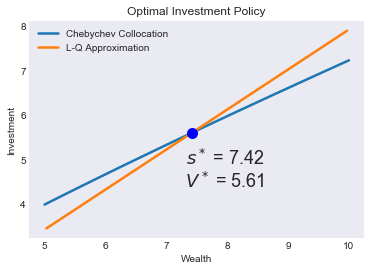

In [13]:
fig1 = demo.figure('Optimal Investment Policy', 'Wealth', 'Investment')
plt.plot(S.Investment, label='Chebychev Collocation')
plt.plot(L.Investment, label='L-Q Approximation')
demo.annotate(sstar, kstar,'$s^*$ = %.2f\n$V^*$ = %.2f' % (sstar, kstar),'bo', (10, -17),ms=10)
plt.legend(loc= 'upper left')

### Value Function

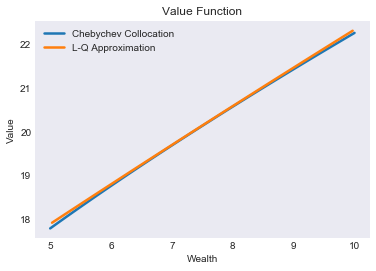

In [14]:
fig2 = demo.figure('Value Function', 'Wealth', 'Value')
plt.plot(S.value, label='Chebychev Collocation')
plt.plot(L.value, label='L-Q Approximation')
plt.legend(loc= 'upper left')

### Shadow Price Function

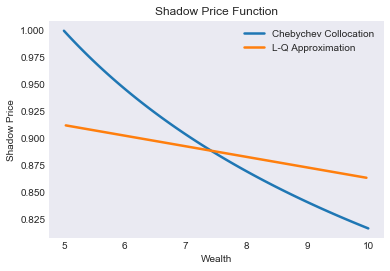

In [15]:
fig3 = demo.figure('Shadow Price Function', 'Wealth', 'Shadow Price')
plt.plot(S['shadow price'], label='Chebychev Collocation')
plt.plot(L['shadow price'], label='L-Q Approximation')
plt.legend(loc= 'upper right')

### Chebychev Collocation Residual

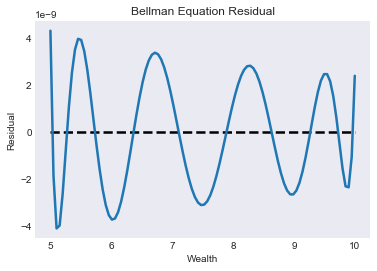

In [16]:
fig4 = demo.figure('Bellman Equation Residual', 'Wealth', 'Residual')
plt.hlines(0,smin,smax,'k',linestyles='--')
plt.plot(S[['resid']])
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

### Wealth dynamics

Notice how the steady-state is stable in the Chebyshev collocation solution, but unstable in the linear-quadratic approximation. In particular, simulated paths of wealth in the L-Q approximation will converge to zero, unless the initial states is within a small neighborhood of the steady-state.

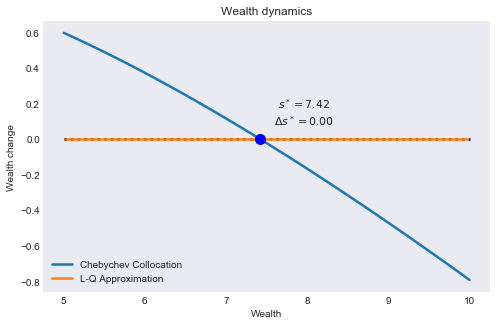

In [17]:
fig5 = demo.figure('Wealth dynamics', 'Wealth', 'Wealth change', figsize=[8,5])
plt.plot(S['D.Wealth'], label='Chebychev Collocation')
plt.plot(L['D.Wealth'], label='L-Q Approximation')
plt.hlines(0,smin,smax,linestyles=':')

demo.annotate(sstar, 0, f'$s^* = {sstar:.2f}$\n$\Delta s^* = {0:.2f}$', 'bo', (10, 10),ms=10,fs=11)
plt.legend(loc= 'lower left')

### Simulating the model

We simulate 21 periods of the model starting from $s=s_{\min}$

In [18]:
T = 21
nrep = 50_000
data = growth_model.simulate(T, np.tile(smin,nrep))

### Simulated State and Policy Paths

In [19]:
subdata = data[data['_rep'].isin(range(3))]
opts = dict(spec='r*', offset=(0, -15), fs=11, ha='right')

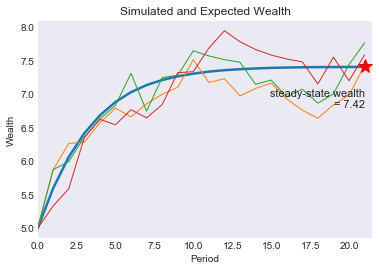

In [20]:
fig6 = demo.figure('Simulated and Expected Wealth','Period', 'Wealth',[0, T + 0.5])
plt.plot(data[['time','Wealth']].groupby('time').mean())
plt.plot(subdata.pivot('time','_rep','Wealth'),lw=1)
demo.annotate(T, sstar, f'steady-state wealth\n = {sstar:.2f}', **opts)

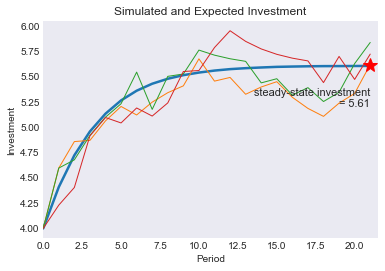

In [21]:
fig7 = demo.figure('Simulated and Expected Investment','Period', 'Investment',[0, T + 0.5])
plt.plot(data[['time','Investment']].groupby('time').mean())
plt.plot(subdata.pivot('time','_rep','Investment'),lw=1)
demo.annotate(T, kstar, f'steady-state investment\n = {kstar:.2f}', **opts)

### Ergodic Wealth Distribution

In [22]:
subdata = data[data['time']==T][['Wealth','Investment']]
stats =pd.DataFrame({'Deterministic Steady-State': [sstar, kstar],
              'Ergodic Means': subdata.mean(),
              'Ergodic Standard Deviations': subdata.std()}).T
stats

,Wealth,Investment
Deterministic Steady-State,7.416898,5.609418
Ergodic Means,7.409230,5.604258
Ergodic Standard Deviations,0.340698,0.220457


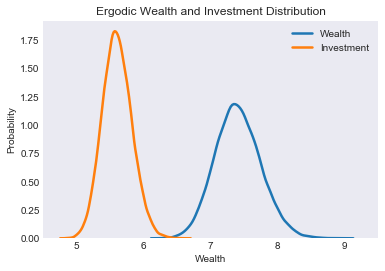

In [23]:
fig8 = demo.figure('Ergodic Wealth and Investment Distribution','Wealth','Probability',[4.5, 9.5])
sns.kdeplot(subdata['Wealth'])
sns.kdeplot(subdata['Investment'])

In [24]:
#demo.savefig([fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8])